In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from multiprocessing import Pool, shared_memory
from scipy.stats import erlang, norm
from scipy.special import erf
import math

In [2]:
def create_Erlang_dist(lamb, k):
    def Erlang_dist(x):
        return erlang.pdf(x, k, scale=1/lamb)
    return Erlang_dist

def create_Erlang_cdf(lamb, k):
    def Erlang_cdf(x):
        return erlang.cdf(x, k, scale=1/lamb)
    return Erlang_cdf

def q1(r, mu, sigma):
    sqrt = np.sqrt
    pi = np.pi
    exp = np.exp 
    return (mu/2)*erf((r-mu)/sqrt(2*sigma*sigma)) - (sigma/sqrt(2*pi))*exp(-(r-mu)**2/(2*sigma*sigma))

def q2(r, mu, sigma, c):
    sqrt = np.sqrt
    pi = np.pi
    exp = np.exp    
    return ( .5*(1-(mu/c))*erf((r-mu)/sqrt(2*sigma*sigma))
            + (sigma/sqrt(2*pi*c*c))*exp(-(r-mu)**2/(2*sigma*sigma)))
def g(r, c):
    arcsin = np.arcsin
    pi = np.pi
    power = np.power
    return (.5 
            + (2*r/(3*c*pi)) 
            - (r/(c*pi))*power(1- (c/r)**2, 1/2)
            + (r/(3*c*pi))*power(1- (c/r)**2, 3/2)
            - (arcsin(c/r)/pi))

def k(r,c):
    pi = np.pi
    arcsin = np.arcsin
    power=np.power
    return ((pi*r/4) 
            - (c/2)*power(1- (c/r)**2, 1/2)
            - (r/2)*arcsin(c/r)
               )    

def K(r,c):
    pi = np.pi
    arcsin = np.arcsin
    power=np.power
    return ((pi*r*c/4) 
            - (1/6)*power(1- (c/r)**2, 1/2)*(2*(r**2) + c**2)
            - (r*c/2)*arcsin(c/r)
               )    

def alpha_exp(n ,lamb, c):
    return ((erlang.pdf(c, n, scale=1/lamb)/lamb) 
           + (1-(n/(c*lamb)))*erlang.cdf(c, n, scale=1/lamb))

def alpha_clt(n, mu, sigma, c):
    return (q2(c,n*mu, np.sqrt(n)*sigma, c) - q2(-c,n*mu, np.sqrt(n)*sigma, c))

def gamma_exp(n ,lamb, c, warning=False, clt=False):
    dist_func = create_Erlang_dist(lamb, n)
    in1, err1 = integrate.quad(lambda r: r*dist_func(r),
                          0, 
                          c, epsabs=0,limit=1000)
    in2, err2 = integrate.quad(lambda r: g(r, c)*dist_func(r),
                                              c, 
                                              np.inf, epsabs=0, limit=1000)
    if  (err1 == 0 or err2 == 0) and warning:
        print(f"Warning in gamma_exp err1:{err1}, err2:{err2}")
        
    if (err1 == 0 or err2 == 0) and clt and (n/lamb) >= c:
        in2 = in2 = g(n/lamb, c)
        
    return (2/(3*c*np.pi))*in1 + in2

def gamma_clt(n, mu, sigma, c):
    sqrt = np.sqrt
    pi = np.pi
    f1 = (2/(3*pi*c))*(q1(c, n*mu, sqrt(n)*sigma)-q1(-c, n*mu, sqrt(n)*sigma))
    if c > n*mu:
        f2 = (2/(3*pi))*(2-erf((c-n*mu)/sqrt(2*n*sigma*sigma))-erf((c+n*mu)/sqrt(2*n*sigma*sigma)))
    else:
        f2 = g(n*mu, c)
    return f1+f2
        

In [3]:
def grad_vec(n, gamma, alpha):
    """Find the gradient field of PI PS"""
    return (-(1-alpha)*np.power(1-gamma*(1-alpha), n-1),
            gamma*np.power(1-gamma*(1-alpha), n-1) - np.power(alpha, n-1))

# Comparing folded-normal off-diagonal with activation samples with the lower bound estimate

In [4]:
repeats = 5
res5 = np.load("P_I_P_S_normal_activation.npy")
ns = np.array([4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512])
ns2 = np.unique(np.arange(4,1024,1).astype(np.int32))
c = 1
activations = np.array([0.0, 0.001, 0.005, 0.01])
sigma = 0.01

stats_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0], repeats))
mean_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0]))
std_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0]))
stats_inc_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0], repeats))
mean_inc_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0]))
std_inc_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0]))
for j,n in enumerate(ns):
    for k,activation in enumerate(activations):
        for t in range(repeats):
            index = j*activations.shape[0]*repeats + k*repeats + t
            stats_super_stable_normal_act[j, k, t ] =   res5[index][1]
            stats_inc_stable_normal_act[j, k, t ] =   res5[index][2]
            
mean_super_stable_normal_act = np.mean(stats_super_stable_normal_act, axis=2)
std_super_stable_normal_act = np.std(stats_super_stable_normal_act, axis=2)
mean_inc_stable_normal_act = np.mean(stats_inc_stable_normal_act, axis=2)
std_inc_stable_normal_act = np.std(stats_inc_stable_normal_act, axis=2)

alphas_act = np.array([alpha_clt(n-1, sigma*np.sqrt(2/np.pi), sigma*np.sqrt(1-(2/np.pi)), c) 
                              for n in ns2])

gammas_act = np.array([gamma_clt(n-1, sigma*np.sqrt(2/np.pi), sigma*np.sqrt(1-(2/np.pi)), c) 
                     for n in ns2])

#### Find where the regime changes

In [5]:
grad_x_dir = np.array([grad_vec(ns[i],gammas_act[i], alphas_act[i])[1] for i in range(ns.shape[0])])
n_different_regime = ns[np.argmax(grad_x_dir > 0)]

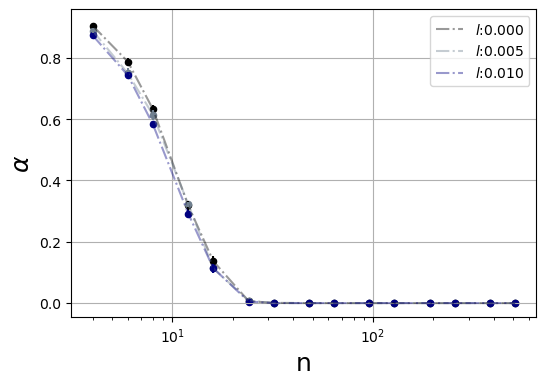

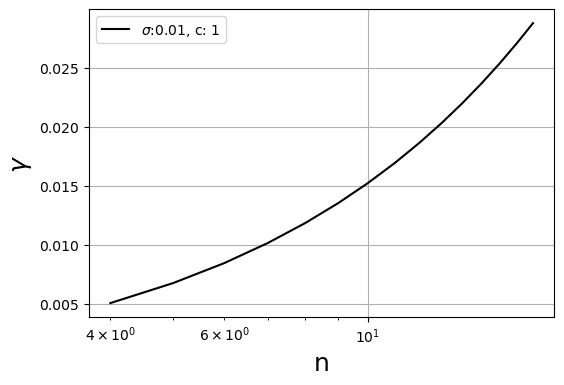

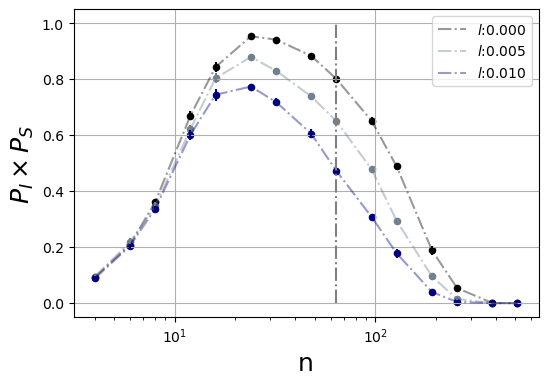

In [6]:

colors = ['black', 'royalblue', 'slategray', 'navy']

plt.figure(figsize=(6,4))
for k,activation in enumerate(activations):
    if k == 1:
        continue
    plt.plot(ns, mean_super_stable_normal_act[:, k],
                 "-.",
                 alpha=.4,
                 c=colors[k%4],
                 label=r"$l$:" f"{activation:.3f}" 
                )
    plt.scatter(ns, mean_super_stable_normal_act[:, k],
                 marker="o",
                 s=20,
                 c=colors[k%4]
                )
    plt.errorbar(ns, mean_super_stable_normal_act[:, k],
                 yerr=std_super_stable_normal_act[:, k], 
                 ls = "None",
                 color = colors[k%4]
                )


plt.xlabel("n", fontsize=18);plt.ylabel(r"$\alpha$", fontsize=18);
plt.legend();plt.grid();plt.xscale('log');plt.show()


plt.figure(figsize=(6,4))
plt.plot(ns2[:ns.shape[0]],
         gammas_act[:ns.shape[0]], 
         '-',
         c=colors[0],
         label=r"$\sigma$:" f"{sigma:2.2f}, c:{c:2.0f}")
    

plt.xlabel("n", fontsize=18);plt.ylabel(r"$\gamma$", fontsize=18);
plt.legend();plt.grid();plt.xscale('log');plt.show()

plt.figure(figsize=(6,4))
for k,activation in enumerate(activations):
    if k == 1:
        continue
    plt.plot(ns, mean_inc_stable_normal_act[:, k],
             "-.",
             alpha=.4,
             c=colors[k%4],
             label=r"$l$:" f"{activation:.3f}"  )
    
    plt.scatter(ns, mean_inc_stable_normal_act[:, k],
                 marker="o",
                 s=20,
                 c=colors[k%4]
                )
    
    plt.errorbar(ns, mean_inc_stable_normal_act[:, k],
                 yerr=std_inc_stable_normal_act[:, k],
                 ls = "None",
                 color = colors[k%4]
                )
    
    
plt.vlines(n_different_regime, 0,1, colors='grey', linestyles='-.')

plt.xlabel("n", fontsize=18);plt.ylabel(r"$P_I \times P_S$", fontsize=18);
plt.legend();plt.grid();plt.xscale('log');plt.show()
    

# Comparing folded-normal off-diagonal with inhibition samples with the lower bound estimate

In [7]:
repeats = 5
res6 = np.load("P_I_P_S_normal_inhibition.npy")
ns = np.array([4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512])
ns2 = np.arange(4,1024).astype(np.int32)
c = 1
inhibitions = np.array([0.0, 0.001, 0.005, 0.01])
sigma = 0.01

stats_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0], repeats))
mean_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0]))
std_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0]))
stats_inc_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0], repeats))
mean_inc_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0]))
std_inc_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0]))
for j,n in enumerate(ns):
    for k,inhibition in enumerate(inhibitions):
        for t in range(repeats):
            index = j*inhibitions.shape[0]*repeats + k*repeats + t
            stats_super_stable_normal_inh[j, k, t ] =   res6[index][1]
            stats_inc_stable_normal_inh[j, k, t ] =   res6[index][2]
            
mean_super_stable_normal_inh = np.mean(stats_super_stable_normal_inh, axis=2)
std_super_stable_normal_inh = np.std(stats_super_stable_normal_inh, axis=2)
mean_inc_stable_normal_inh = np.mean(stats_inc_stable_normal_inh, axis=2)
std_inc_stable_normal_inh = np.std(stats_inc_stable_normal_inh, axis=2)

alphas_inh = np.array([alpha_clt(n-1, sigma*np.sqrt(2/np.pi), sigma*np.sqrt(1-(2/np.pi)), c) 
                              for n in ns2])

gammas_inh = np.array([gamma_clt(n-1, sigma*np.sqrt(2/np.pi), sigma*np.sqrt(1-(2/np.pi)), c) 
                     for n in ns2])

In [8]:
grad_x_dir = np.array([grad_vec(ns[i],gammas_inh[i], alphas_inh[i])[1] for i in range(ns.shape[0])])
n_different_regime = ns[np.argmax(grad_x_dir > 0)]

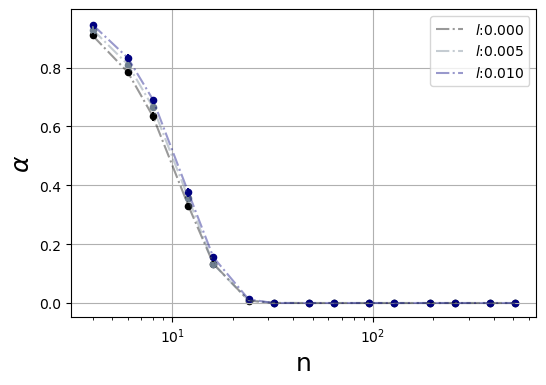

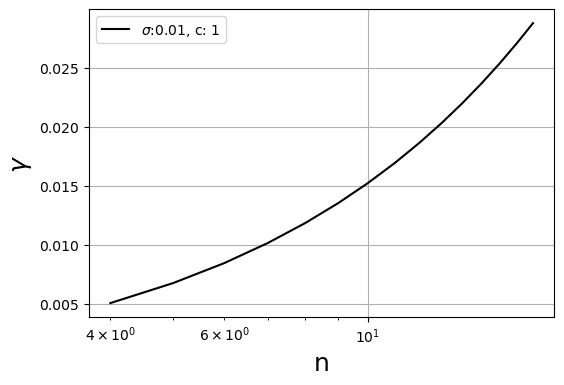

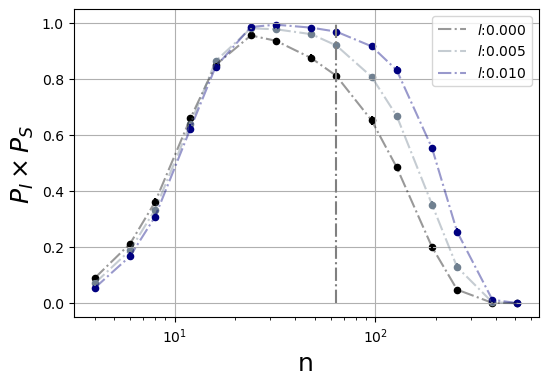

In [9]:


colors = ['black', 'royalblue','slategray', 'navy']

plt.figure(figsize=(6,4))
for k,inhibition in enumerate(inhibitions):
    if k == 1:
        continue
    plt.plot(ns, mean_super_stable_normal_inh[:, k],
                 "-.",
                 alpha=.4,
                 c=colors[k%4],
                 label=r"$l$:" f"{inhibition:.3f}" 
                )
    plt.scatter(ns, mean_super_stable_normal_inh[:, k],
                 marker="o",
                 s=20,
                 c=colors[k%4]
                )
    plt.errorbar(ns, mean_super_stable_normal_inh[:, k],
                 yerr=std_super_stable_normal_inh[:, k], 
                 ls = "None",
                 color = colors[k%4]
                )


plt.xlabel("n", fontsize=18);plt.ylabel(r"$\alpha$", fontsize=18);
plt.legend();plt.grid();plt.xscale('log');plt.show()

plt.figure(figsize=(6,4))
plt.plot(ns2[:ns.shape[0]],
         gammas_inh[:ns.shape[0]], 
         '-',
         c=colors[0],
         label=r"$\sigma$:" f"{sigma:2.2f}, c:{c:2.0f}")
    

plt.xlabel("n", fontsize=18);plt.ylabel(r"$\gamma$", fontsize=18);
plt.legend();plt.grid();plt.xscale('log');plt.show()


plt.figure(figsize=(6,4))
for k,inhibition in enumerate(inhibitions):
    if k == 1:
        continue
    plt.plot(ns, mean_inc_stable_normal_inh[:, k],
             "-.",
             alpha=.4,
             c=colors[k%4],
             label=r"$l$:" f"{inhibition:.3f}"  )
    
    plt.scatter(ns, mean_inc_stable_normal_inh[:, k],
                 marker="o",
                 s=20,
                 c=colors[k%4]
                )
    
    plt.errorbar(ns, mean_inc_stable_normal_inh[:, k],
                 yerr=std_inc_stable_normal_inh[:, k],
                 ls = "None",
                 color = colors[k%4]
                )
    
    
plt.vlines(n_different_regime, 0,1, colors='grey', linestyles='-.')


plt.xlabel("n", fontsize=18);plt.ylabel(r"$P_I \times P_S$", fontsize=18);
plt.legend();plt.grid();plt.xscale('log');plt.show()
    

# Repeat the estimates for random self-activations

In [10]:
repeats = 5
res5 = np.load("P_I_P_S_normal_activation_random.npy")
ns = np.array([4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512])
ns2 = np.unique(np.arange(4,1024,1).astype(np.int32))
c = 1
activations = np.array([0.0, 0.001, 0.005, 0.01])
sigma = 0.01

stats_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0], repeats))
mean_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0]))
std_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0]))
stats_inc_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0], repeats))
mean_inc_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0]))
std_inc_super_stable_normal_act = np.zeros((ns.shape[0], activations.shape[0]))
for j,n in enumerate(ns):
    for k,activation in enumerate(activations):
        for t in range(repeats):
            index = j*activations.shape[0]*repeats + k*repeats + t
            stats_super_stable_normal_act[j, k, t ] =   res5[index][1]
            stats_inc_stable_normal_act[j, k, t ] =   res5[index][2]
            
mean_super_stable_normal_act = np.mean(stats_super_stable_normal_act, axis=2)
std_super_stable_normal_act = np.std(stats_super_stable_normal_act, axis=2)
mean_inc_stable_normal_act = np.mean(stats_inc_stable_normal_act, axis=2)
std_inc_stable_normal_act = np.std(stats_inc_stable_normal_act, axis=2)

alphas_act = np.array([alpha_clt(n-1, sigma*np.sqrt(2/np.pi), sigma*np.sqrt(1-(2/np.pi)), c) 
                              for n in ns2])

gammas_act = np.array([gamma_clt(n-1, sigma*np.sqrt(2/np.pi), sigma*np.sqrt(1-(2/np.pi)), c) 
                     for n in ns2])

In [11]:
grad_x_dir = np.array([grad_vec(ns[i],gammas_act[i], alphas_act[i])[1] for i in range(ns.shape[0])])
n_different_regime = ns[np.argmax(grad_x_dir > 0)]

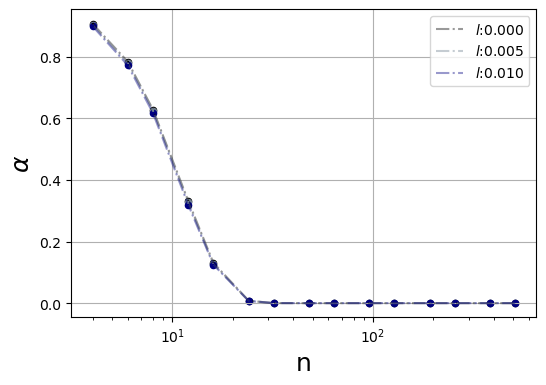

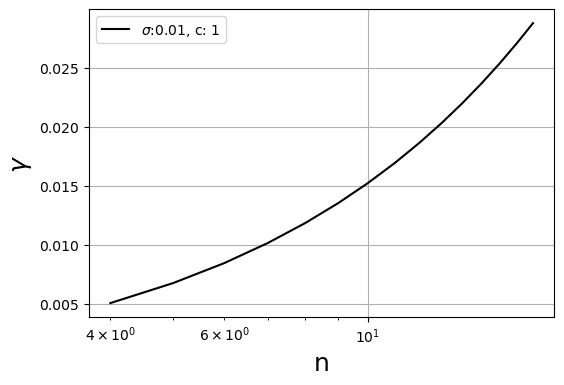

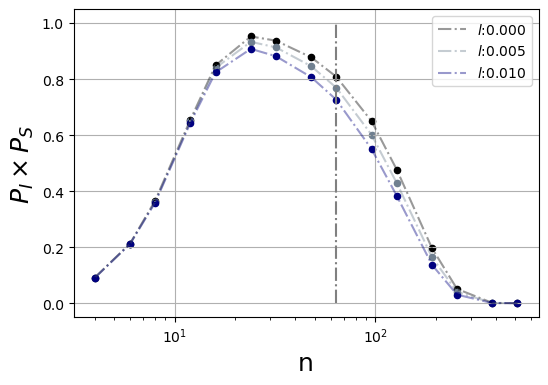

In [12]:

colors = ['black', 'royalblue', 'slategray', 'navy']

plt.figure(figsize=(6,4))
for k,activation in enumerate(activations):
    if k == 1:
        continue
    plt.plot(ns, mean_super_stable_normal_act[:, k],
                 "-.",
                 alpha=.4,
                 c=colors[k%4],
                 label=r"$l$:" f"{activation:.3f}" 
                )
    plt.scatter(ns, mean_super_stable_normal_act[:, k],
                 marker="o",
                 s=20,
                 c=colors[k%4]
                )
    plt.errorbar(ns, mean_super_stable_normal_act[:, k],
                 yerr=std_super_stable_normal_act[:, k], 
                 ls = "None",
                 color = colors[k%4]
                )


plt.xlabel("n", fontsize=18);plt.ylabel(r"$\alpha$", fontsize=18);
plt.legend();plt.grid();plt.xscale('log');plt.show()


plt.figure(figsize=(6,4))
plt.plot(ns2[:ns.shape[0]],
         gammas_act[:ns.shape[0]], 
         '-',
         c=colors[0],
         label=r"$\sigma$:" f"{sigma:2.2f}, c:{c:2.0f}")
    

plt.xlabel("n", fontsize=18);plt.ylabel(r"$\gamma$", fontsize=18);
plt.legend();plt.grid();plt.xscale('log');plt.show()

plt.figure(figsize=(6,4))
for k,activation in enumerate(activations):
    if k == 1:
        continue
    plt.plot(ns, mean_inc_stable_normal_act[:, k],
             "-.",
             alpha=.4,
             c=colors[k%4],
             label=r"$l$:" f"{activation:.3f}"  )
    
    plt.scatter(ns, mean_inc_stable_normal_act[:, k],
                 marker="o",
                 s=20,
                 c=colors[k%4]
                )
    
    plt.errorbar(ns, mean_inc_stable_normal_act[:, k],
                 yerr=std_inc_stable_normal_act[:, k],
                 ls = "None",
                 color = colors[k%4]
                )
    
    
plt.vlines(n_different_regime, 0,1, colors='grey', linestyles='-.')

plt.xlabel("n", fontsize=18);plt.ylabel(r"$P_I \times P_S$", fontsize=18);
plt.legend();plt.grid();plt.xscale('log');plt.show()
    

# Repeat the estimates for random self-inhibition

In [13]:
repeats = 5
res6 = np.load("P_I_P_S_normal_inhibition_random.npy")
ns = np.array([4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512])#, 768, 1024])
ns2 = np.arange(4,1024).astype(np.int32)
c = 1

inhibitions = np.array([0.0, 0.001, 0.005, 0.01])
sigma = 0.01

stats_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0], repeats))
mean_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0]))
std_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0]))
stats_inc_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0], repeats))
mean_inc_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0]))
std_inc_super_stable_normal_inh = np.zeros((ns.shape[0], inhibitions.shape[0]))
for j,n in enumerate(ns):
    for k,inhibition in enumerate(inhibitions):
        for t in range(repeats):
            index = j*inhibitions.shape[0]*repeats + k*repeats + t
            stats_super_stable_normal_inh[j, k, t ] =   res6[index][1]
            stats_inc_stable_normal_inh[j, k, t ] =   res6[index][2]
            
mean_super_stable_normal_inh = np.mean(stats_super_stable_normal_inh, axis=2)
std_super_stable_normal_inh = np.std(stats_super_stable_normal_inh, axis=2)
mean_inc_stable_normal_inh = np.mean(stats_inc_stable_normal_inh, axis=2)
std_inc_stable_normal_inh = np.std(stats_inc_stable_normal_inh, axis=2)

alphas_inh = np.array([alpha_clt(n-1, sigma*np.sqrt(2/np.pi), sigma*np.sqrt(1-(2/np.pi)), c) 
                              for n in ns2])

gammas_inh = np.array([gamma_clt(n-1, sigma*np.sqrt(2/np.pi), sigma*np.sqrt(1-(2/np.pi)), c) 
                     for n in ns2])

In [14]:
grad_x_dir = np.array([grad_vec(ns[i],gammas_inh[i], alphas_inh[i])[1] for i in range(ns.shape[0])])
n_different_regime = ns[np.argmax(grad_x_dir > 0)]

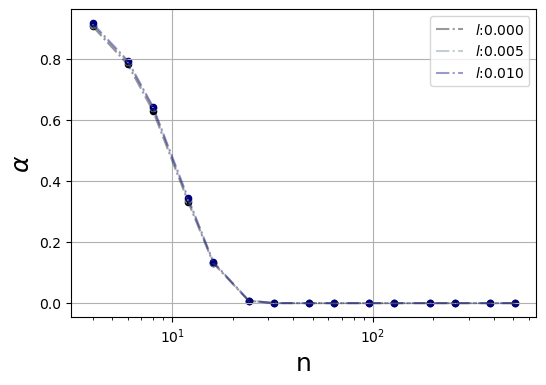

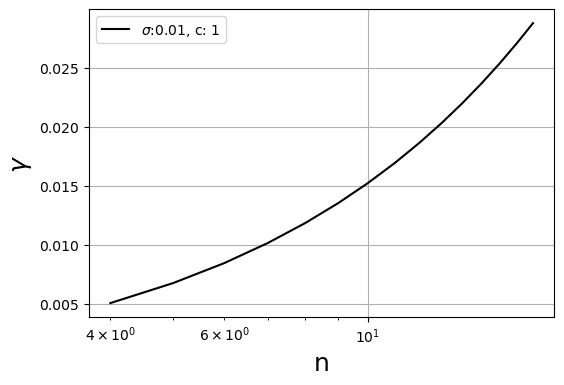

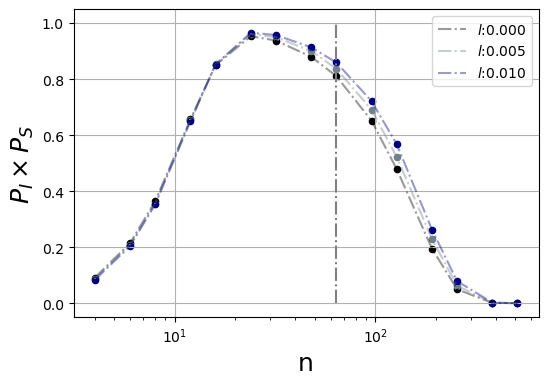

In [15]:


colors = ['black', 'royalblue','slategray', 'navy']

plt.figure(figsize=(6,4))
for k,inhibition in enumerate(inhibitions):
    if k == 1:
        continue
    plt.plot(ns, mean_super_stable_normal_inh[:, k],
                 "-.",
                 alpha=.4,
                 c=colors[k%4],
                 label=r"$l$:" f"{inhibition:.3f}" 
                )
    plt.scatter(ns, mean_super_stable_normal_inh[:, k],
                 marker="o",
                 s=20,
                 c=colors[k%4]
                )
    plt.errorbar(ns, mean_super_stable_normal_inh[:, k],
                 yerr=std_super_stable_normal_inh[:, k], 
                 ls = "None",
                 color = colors[k%4]
                )


plt.xlabel("n", fontsize=18);plt.ylabel(r"$\alpha$", fontsize=18);  
plt.legend();plt.grid();plt.xscale('log');plt.show()

plt.figure(figsize=(6,4))
plt.plot(ns2[:ns.shape[0]],
         gammas_inh[:ns.shape[0]], 
         '-',
         c=colors[0],
         label=r"$\sigma$:" f"{sigma:2.2f}, c:{c:2.0f}")
    

plt.xlabel("n", fontsize=18);plt.ylabel(r"$\gamma$", fontsize=18);    
plt.legend();plt.grid();plt.xscale('log');plt.show()


plt.figure(figsize=(6,4))
for k,inhibition in enumerate(inhibitions):
    if k == 1:
        continue
    plt.plot(ns, mean_inc_stable_normal_inh[:, k],
             "-.",
             alpha=.4,
             c=colors[k%4],
             label=r"$l$:" f"{inhibition:.3f}"  )
    
    plt.scatter(ns, mean_inc_stable_normal_inh[:, k],
                 marker="o",
                 s=20,
                 c=colors[k%4]
                )
    
    plt.errorbar(ns, mean_inc_stable_normal_inh[:, k],
                 yerr=std_inc_stable_normal_inh[:, k],
                 ls = "None",
                 color = colors[k%4]
                )
    
    

plt.vlines(n_different_regime, 0,1, colors='grey', linestyles='-.')


plt.xlabel("n", fontsize=18);plt.ylabel(r"$P_I \times P_S$", fontsize=18);   
plt.legend();plt.grid();plt.xscale('log');plt.show()
    